# **1.**  **Importing** **Libraries**

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries imported')

Libraries imported


# **2.** **Importing** **the** **data** 

In [43]:
df = pd.read_csv('data.csv',names = column_names,header=0)
#column_names are those which we have mentioned in utils file ,so here it will be displayed with those column names
df.head()  #head is used to display first five entries of dataset



,serial,date,age,distance,stores,latitude,longitude,price
0,1,2007,4,2,3,86,121,12032
1,2,2016,18,3,7,90,120,13560
2,3,2002,13,2,2,80,128,12029
3,4,2014,25,5,8,81,122,14157
4,5,2008,11,9,3,88,126,14287


# **3.** **Check Missing Data**

In [44]:
#It's a good practice to check if the data has any missing values. 
df.isna().sum()
#it shows the sum of na values present in each column

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# **4.** **Data Normalization**

In [45]:
#data normalization is an important step 
#it is used to change the values so that they can be in common range without distorting difference between them 
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,-0.350447,-1.318954,-0.930413,-0.609189,0.325211,-1.261125,-1.836255
1,1.298471,-0.083366,-0.617878,0.663413,1.590122,-1.576801,-0.339484
2,-1.266513,-0.524647,-0.930413,-0.927340,-1.572157,0.948607,-1.839193
3,0.932045,0.534428,0.007190,0.981564,-1.255929,-0.945449,0.245315
4,-0.167234,-0.701160,1.257326,-0.609189,0.957666,0.317255,0.372658


# **5.** **Convert Label Value**

In [46]:
'''Because we are using normalized values for the labels,
we will get the predictions back from a trained model in the same distribution
that is in normalized form.
So, we need to convert the predicted values back to the original distribution
if we want predicted prices.'''

y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# **6. Create Training and Test sets**

### 6.1 Select Features i.e. Independent variables(X)

In [47]:
"""X will contain all the independent variables i.e. all columns
except 'price' as it is dependent variable it will be in features list"""
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,-0.350447,-1.318954,-0.930413,-0.609189,0.325211,-1.261125
1,1.298471,-0.083366,-0.617878,0.663413,1.590122,-1.576801
2,-1.266513,-0.524647,-0.930413,-0.927340,-1.572157,0.948607
3,0.932045,0.534428,0.007190,0.981564,-1.255929,-0.945449
4,-0.167234,-0.701160,1.257326,-0.609189,0.957666,0.317255


### 6.2 Select Lables i.e. dependent variables(Y) 

In [48]:
#it will contain 'price'
Y = df_norm.iloc[:, -1]
Y.head()

0   -1.836255
1   -0.339484
2   -1.839193
3    0.245315
4    0.372658
Name: price, dtype: float64

### 6.2 Features and Lables Values

In [49]:
'''We will need to extract just the numeric values for the features and
labels as the TensorFlow model will expect just numeric values as input.'''
X_arr = X.values
Y_arr = Y.values
#values usually gives the list of values ,here it will give list of all values present in X

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (4999, 6)
Y_arr shape:  (4999,)


### 6.3 Train and Test Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)
'''test_sizefloat, int or None, optional (default=None) ---
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset
to include in the test split. If int, represents the absolute number of test 
samples. If None, the value is set to the complement of the train size. 
If train_size is also None, it will be set to 0.25.'''

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4749, 6)
y_train shape:  (4749,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# **7. Create the model**

In [51]:
#a function that returns an untrained model of a certain architecture.
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_9 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# **8. Model Training**

### 8.1 Model Training

In [57]:
'''We can use an EarlyStopping callback from Keras to stop the model training
 if the validation loss stops decreasing for a few epochs.'''
'''train multiple number of times to get good graph'''

early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8829 - val_loss: 0.7650
Epoch 2/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8821 - val_loss: 0.7643
Epoch 3/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8812 - val_loss: 0.7637
Epoch 4/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8804 - val_loss: 0.7630
Epoch 5/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8796 - val_loss: 0.7624
Epoch 6/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8788 - val_loss: 0.7617
Epoch 7/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8780 - val_loss: 0.7610
Epoch 8/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8772 - val_loss: 0.7604
Epoch 9/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8764 - val_loss: 0.7598
Epoch 10/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.875

### 8.2 Plot Training and Validation Loss

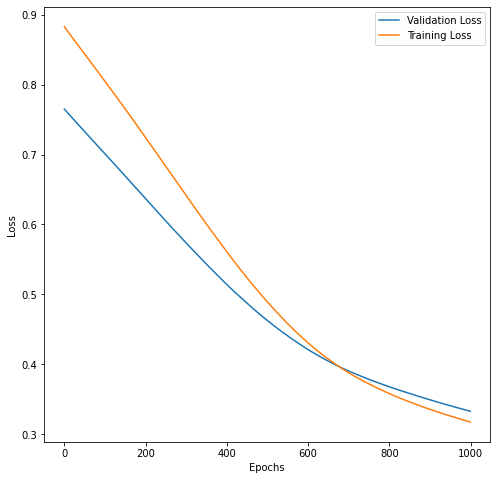

In [58]:
plot_loss(history)

# **9. Prediction**

### 9.1 Plot Raw Prediction

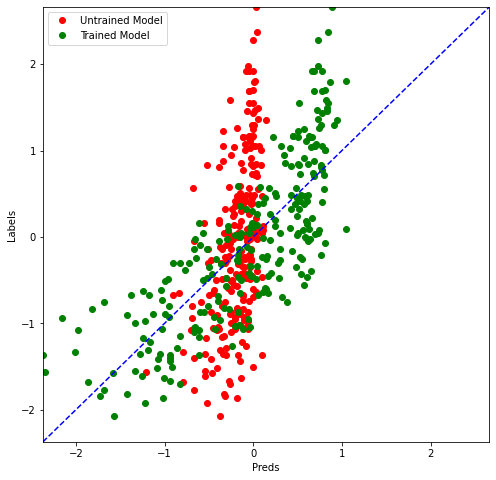

In [59]:
'''Let's use the compare_predictions helper function to compare predictions from
the model when it was untrained and when it was trained.'''

preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

### 9.2 Plot Price Prediction

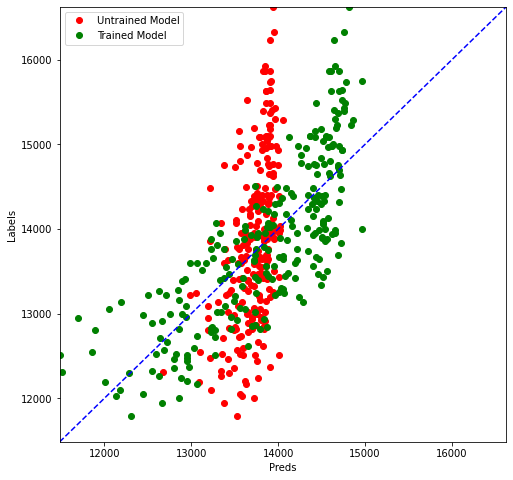

In [60]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)